In [1]:
import pandas as pd
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
import numpy as np

from pprint import pprint
from IPython.display import display
from typing import Dict, Union, List, Callable, Tuple
from pathlib import Path

import lib.analysis

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from tqdm.notebook import tqdm
tqdm.pandas()

%matplotlib inline

sns.set_style('darkgrid')
sns.set_context('notebook')

pd.set_option('max_columns', None)

In [2]:
folderpath = Path('data/UAH-DRIVESET-v1/')

## Data Preparation

In [ ]:
df = pd.read_parquet(Path(folderpath, 'data_ready.parquet'))
df = df.sort_values(['corner_select', 'timestamp'])

In [ ]:
dfout = pd.read_parquet(Path(folderpath, 'dl_gan', 'output.parquet'))

In [ ]:
split_by = 'corner_select'

## Cluster verification

Because I pad the sequences, I make sure that the GAN did not cluster by event length.

In [6]:
dfout['length'] = df.groupby(split_by)[split_by].count()

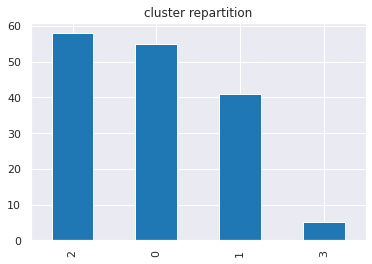

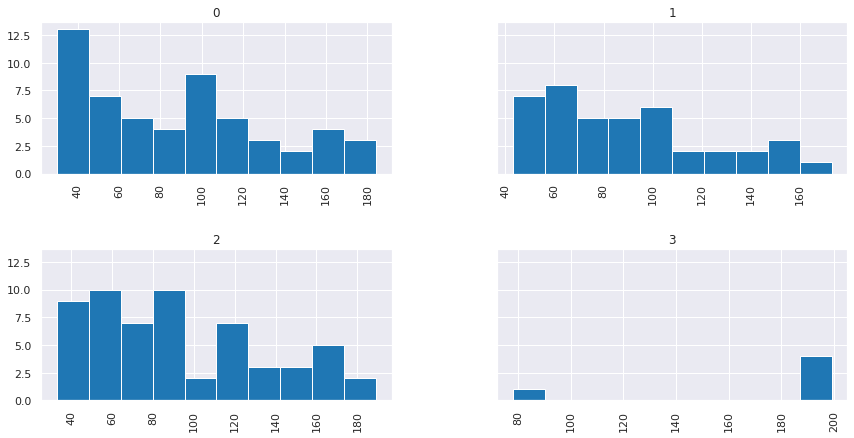

In [7]:
dfout['cluster'].value_counts().plot(kind='bar', title='cluster repartition');
dfout['length'].hist(by=dfout['cluster'], sharey=True, figsize=(14, 7));

## Data processing for lineplot normalized
We need to interpolate the data to have them all at the same size and then apply the quantile.
We will apply this _elastic_ quantile for each features in relation to the **time_event_norm**

In [8]:
df['time_event_norm'] = df.groupby(split_by)['time_event'].apply(
    lambda x: x / x.max()
)

df = df.merge(dfout['cluster'], on=split_by)

col = [
    'gx',
    'gy',
    'yr',
    'speed',
    'distx',
    'disty',
    'time_event_norm',
    'corner_select',
    'cluster'
]

In [10]:
from scipy.interpolate import interp1d
from pandas.api.types import is_numeric_dtype

res = 0.01

def interpolate(y:pd.Series, x):
    xnew = np.arange(0, 1+res, res)
    if ~is_numeric_dtype(y):
        return y.reindex(xnew, method='ffill')
    f = interp1d(x, y, kind='cubic', fill_value='extrapolate')
    return pd.Series(f(xnew), index=xnew)

df_norm = df[col]\
    .set_index('time_event_norm')\
    .groupby(split_by, group_keys=False)\
    .apply(lambda x: x.apply(lambda col: interpolate(col, col.index)))

df_norm = df_norm.reset_index()
df_norm = df_norm.set_index('time_event_norm')

display(df_norm.head())

,gx,gy,yr,speed,distx,disty,corner_select,cluster
time_event_norm,,,,,,,,
0.00,-4.212635,-3.131816,-0.038236,89.878333,0.000000,0.000000,12km-D5-AGGRESSIVE-SECONDARY28x41,2
0.01,-1.371846,-3.034051,-0.036860,89.935000,2.488958,-0.205222,12km-D5-AGGRESSIVE-SECONDARY28x41,2
0.02,-0.447022,-0.767433,-0.030044,90.048333,7.479144,-0.502628,12km-D5-AGGRESSIVE-SECONDARY28x41,2
0.03,-2.037298,-0.662346,-0.029180,90.105000,9.979150,-0.605615,12km-D5-AGGRESSIVE-SECONDARY28x41,2
0.04,0.355310,-3.270595,-0.029761,90.218333,14.978730,-0.900846,12km-D5-AGGRESSIVE-SECONDARY28x41,2


## 2D plots with T-SNE and UMAP

First plot is from encoded data and second is the input data
We expect the decoded 2D plot to be more relevant as the GAN is supposed to extract the "essence" of each sequence

In [27]:
from umap import UMAP
from sklearn.manifold import TSNE

def plot_proj(df:pd.DataFrame, mdls:Union[UMAP, TSNE], title:str):
    fig, axes = plt.subplots(nrows=1, ncols=len(mdls))
    fig.set_size_inches(30,7)

    for k, mdl in enumerate(mdls):
        X = mdl.fit_transform(df)
        axes[k].scatter(
            [x[0] for x in X],
            [x[1] for x in X],
            c=dfout['cluster'].reindex(df.index),
            cmap='Set2'
        )
    fig.show()
    fig.suptitle(title)

In [28]:
data_decoder = dfout.loc[:, dfout.columns.str.contains('encode')]
input_data = df_norm.pivot_table(values=['gx','gy','yr','speed'], index=[split_by], columns='time_event_norm')

display(data_decoder.head())
display(input_data.head())

,encode_0,encode_1,encode_2,encode_3,encode_4,encode_5,encode_6,encode_7
corner_select,,,,,,,,
12km-D5-AGGRESSIVE-SECONDARY28x41,0.044137,0.717148,-0.910041,0.136094,-0.142731,0.942378,0.169816,-1.096735
12km-D5-AGGRESSIVE-SECONDARY56x01,0.530999,0.383051,-0.529608,0.101580,0.286603,0.199557,0.831332,-0.090387
12km-D5-AGGRESSIVE-SECONDARY6x91,0.734869,-0.370584,-0.845876,-1.042340,-0.242826,-0.055261,1.520784,0.727375
13km-D1-DROWSY-SECONDARY2x14,-0.644983,0.491528,-0.238239,-0.152461,-0.754647,-0.244120,-0.659645,-0.457272
13km-D1-DROWSY-SECONDARY61x24,0.232243,0.884134,-0.785839,0.323067,0.370795,0.924723,0.601011,-0.909765


gx                                \
time_event_norm                        0.00      0.01      0.02      0.03   
corner_select                                                               
12km-D5-AGGRESSIVE-SECONDARY28x41 -4.212635 -1.371846 -0.447022 -2.037298   
12km-D5-AGGRESSIVE-SECONDARY56x01 -1.435736 -1.435736 -1.435736 -0.146512   
12km-D5-AGGRESSIVE-SECONDARY6x91   1.688896  1.308086 -2.673153  0.909454   
13km-D1-DROWSY-SECONDARY2x14      -1.059322 -1.059322 -1.059322  1.501342   
13km-D1-DROWSY-SECONDARY61x24     -0.390793 -1.879937 -4.108060 -4.806243   

                                                                           \
time_event_norm                        0.04      0.05      0.06      0.07   
corner_select                                                               
12km-D5-AGGRESSIVE-SECONDARY28x41  0.355310 -3.706220 -5.159875 -2.325863   
12km-D5-AGGRESSIVE-SECONDARY56x01 -0.146512  0.817493  0.817493  0.817493   
12km-D5-AGGRESSIVE-SECONDARY6x91   1.686584 -2.012181 -5.752974 -1.932987   
13km-D1-DROWSY-SECONDARY2x14       1.501342  2.096481  2.096481  3.873965   
13km-D1-DROWSY-SECONDARY61x24      4.254050  4.353852 -4.520939 -0.975402   

                                                                           \
time_event_norm                        0.08      0.09      0.10      0.11   
corner_select                                                               
12km-D5-AGGRESSIVE-SECONDARY28x41  4.003213  4.003595  3.829422  5.391690   
12km-D5-AGGRESSIVE-SECONDARY56x01  0.246007  0.246007 -0.406355 -0.406355   
12km-D5-AGGRESSIVE-SECONDARY6x91   1.806642  4.930818 -2.017523 -5.745080   
13km-D1-DROWSY-SECONDARY2x14       3.873965  3.873965  3.906987  3.906987   
13km-D1-DROWSY-SECONDARY61x24     -1.034291 -2.967871 -3.712466 -0.486249   

                                                                           \
time_event_norm                        0.12      0.13      0.14      0.15   
corner_select                                                               
12km-D5-AGGRESSIVE-SECONDARY28x41  6.868383  7.879991  7.214424  2.023987   
12km-D5-AGGRESSIVE-SECONDARY56x01 -0.406355  0.252329  0.252329  0.777254   
12km-D5-AGGRESSIVE-SECONDARY6x91  -4.509401 -4.185064  0.615704 -2.340764   
13km-D1-DROWSY-SECONDARY2x14       0.245176  0.245176 -2.577311 -2.577311   
13km-D1-DROWSY-SECONDARY61x24      0.848528  2.786254 -0.243966 -2.135694   

                                                                           \
time_event_norm                        0.16      0.17      0.18      0.19   
corner_select                                                               
12km-D5-AGGRESSIVE-SECONDARY28x41 -0.982897  0.072130 -0.064982 -1.913091   
12km-D5-AGGRESSIVE-SECONDARY56x01  0.777254  0.777254 -1.460715 -1.460715   
12km-D5-AGGRESSIVE-SECONDARY6x91  -7.129372  4.000217  4.126935 -1.706353   
13km-D1-DROWSY-SECONDARY2x14      -1.461553 -1.461553 -1.461553  1.604376   
13km-D1-DROWSY-SECONDARY61x24     -0.960385 -2.324086 -0.124559  0.781559   

                                                                           \
time_event_norm                        0.20      0.21      0.22      0.23   
corner_select                                                               
12km-D5-AGGRESSIVE-SECONDARY28x41 -1.279581  2.239923 -0.302974 -0.543384   
12km-D5-AGGRESSIVE-SECONDARY56x01 -4.856153 -4.856153 -5.142316 -5.142316   
12km-D5-AGGRESSIVE-SECONDARY6x91  -6.705124 -6.111153 -1.987668 -0.213581   
13km-D1-DROWSY-SECONDARY2x14       1.604376  3.845420  3.845420  4.108524   
13km-D1-DROWSY-SECONDARY61x24     -3.593023 -2.866295  0.372249  0.075484   

                                                                            \
time_event_norm                        0.24      0.25       0.26      0.27   
corner_select                                                                
12km-D5-AGGRESSIVE-SECONDARY28x41 -1.412885 -7.459366 -10.156066  2.137458   
12km-D5-AGGRESSIVE-SECONDAR

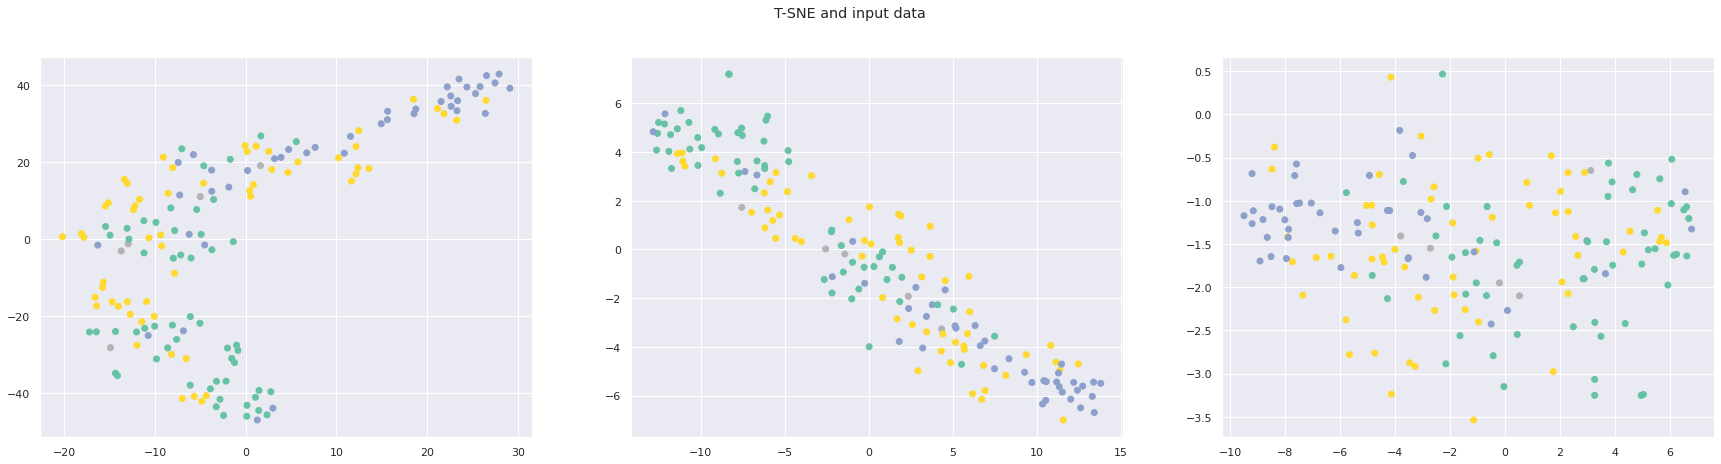

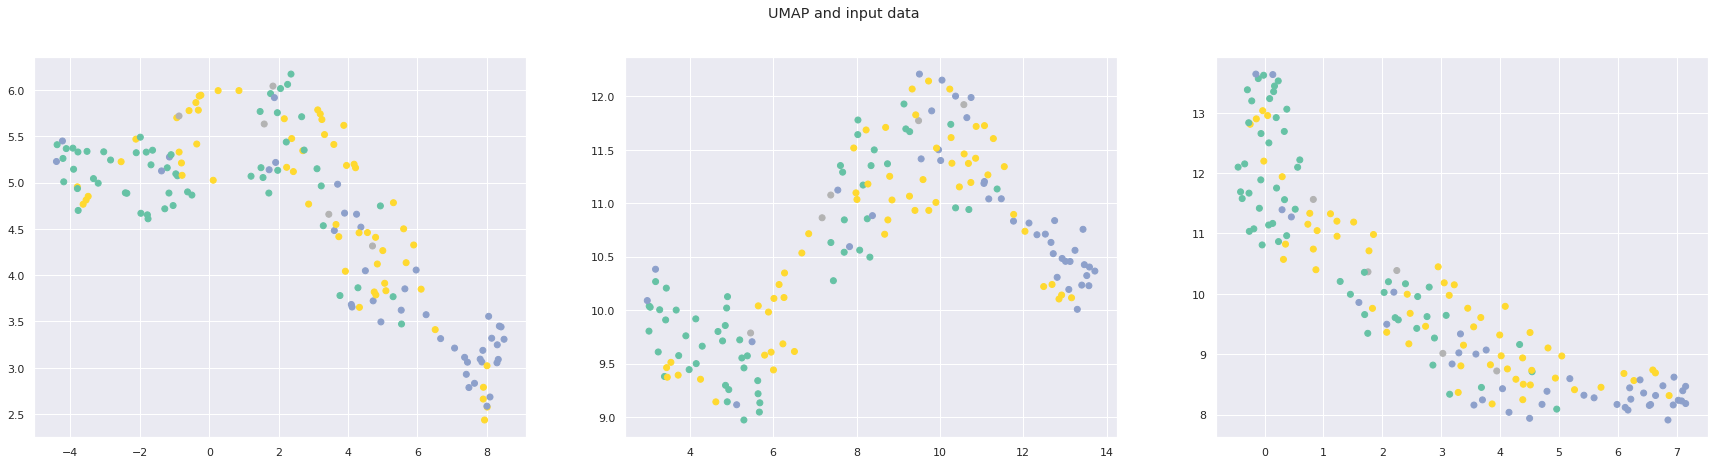

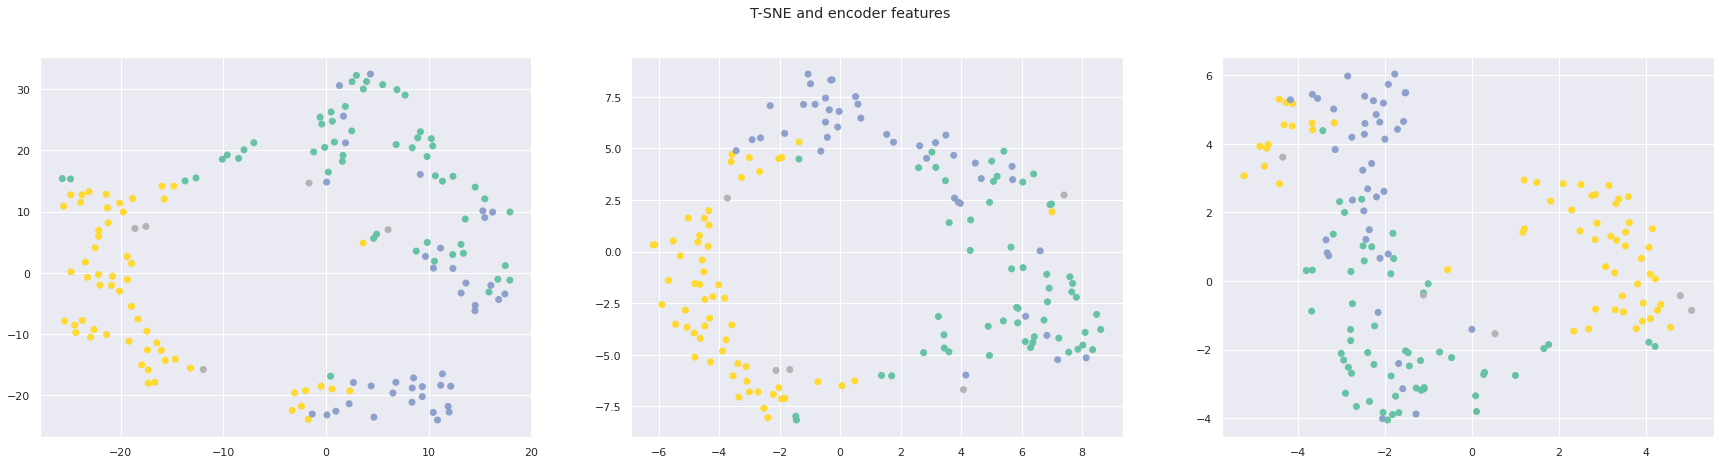

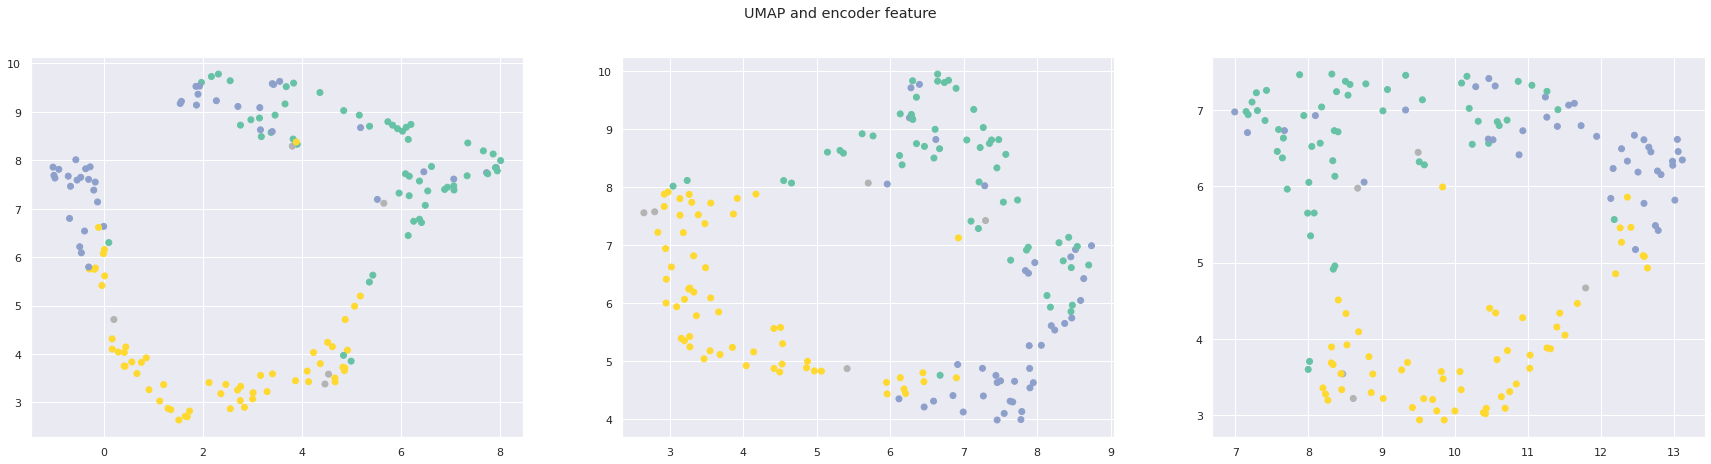

In [60]:
plot_proj(input_data, [TSNE(perplexity=p) for p in [10, 30, 50]], 'T-SNE and Input data')
plot_proj(input_data, [UMAP(n_neighbors=p) for p in [15, 50, 100]], 'UMAP and Input data')

plot_proj(data_decoder, [TSNE(perplexity=p) for p in [10, 30, 50]], 'T-SNE and Encoder features')
plot_proj(data_decoder, [UMAP(n_neighbors=p) for p in [15, 50, 100]], 'UMAP and Encoder feature')

## Time-plot with statistical ranges

Here the sequence are plotted from their inputs by cluster, on X it is the time per event in percentage.
This helps verify that the clusters make sense (after an human review)

I will add quantile lines on the graph.

Safety check because behaviour of scipy.interp with NaN is undefined

In [35]:
df[col].isna().sum()

gx                 0
gy                 0
yr                 0
speed              0
distx              0
disty              0
time_event_norm    0
corner_select      0
cluster            0
dtype: int64

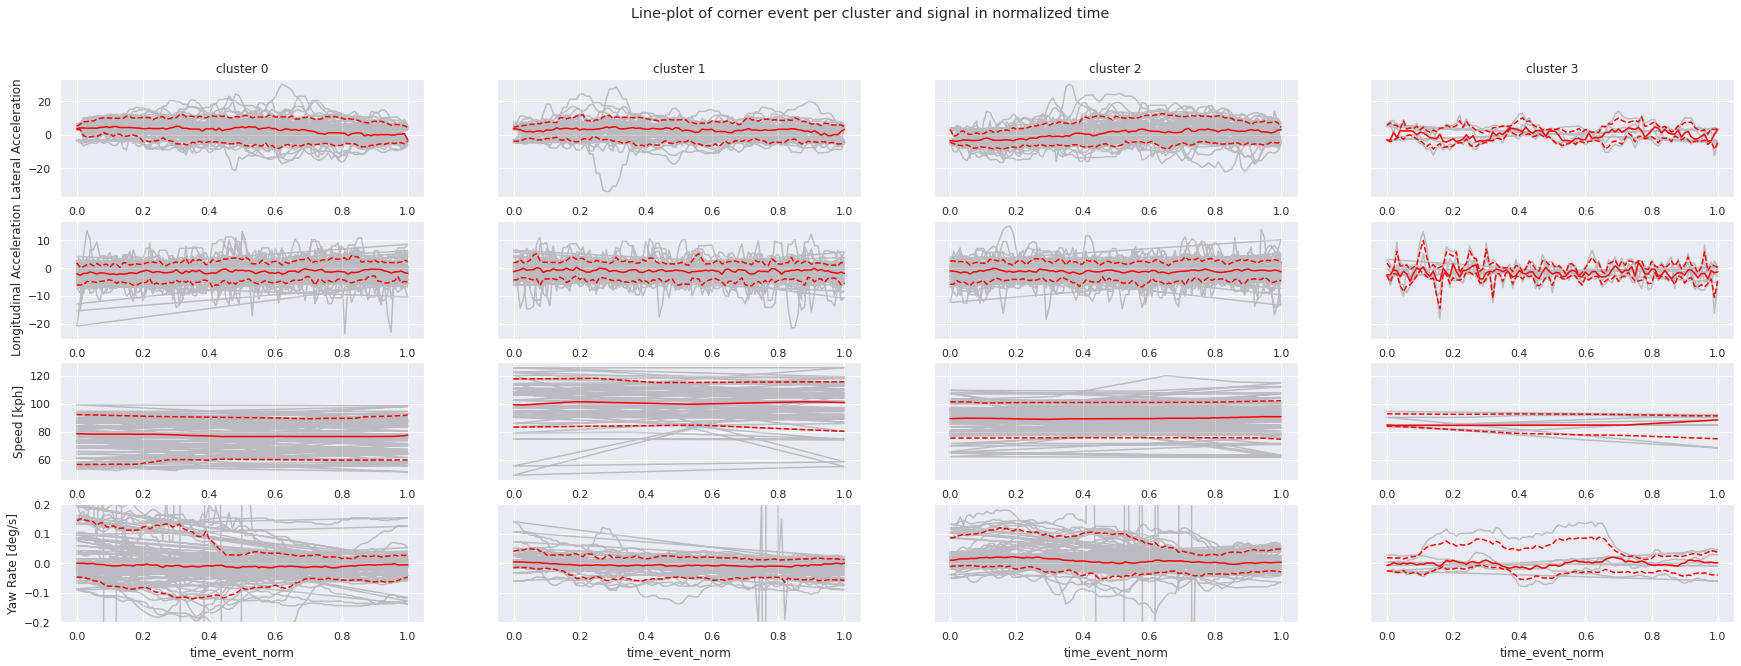

In [34]:
labels = dfout['cluster'].unique()

fig, axes = plt.subplots(ncols=max(labels)+1, nrows=4, figsize=(30, 10), sharey='row')
fig.suptitle('Line-plot of corner event per cluster and signal in normalized time')

for cluster in sorted(labels):
    df_cluster = df_norm.query(f'cluster=={cluster}')\
                        [['gy', 'gx', 'speed', 'yr']]
    
    gb = df_cluster.groupby(level=0)
    df_median = gb.median()
    df_down = gb.quantile(0.10)
    df_up = gb.quantile(0.90)

    def plot_with_quantile(col, name, k, **kwargs):
        if k == 0:
            title_str = f'cluster {cluster}'
        else:
            title_str = None
        df_cluster[col].plot(ax=axes[k, cluster], alpha=0.2, style='k', title=title_str, **kwargs)
        df_median[col].plot(ax=axes[k, cluster], style='r', **kwargs)
        df_down[col].plot(ax=axes[k, cluster], style='r--', **kwargs)
        df_up[col].plot(ax=axes[k, cluster], style='r--', **kwargs)
        axes[k, cluster].set_ylabel(name)

    plot_with_quantile('gy', 'Lateral Acceleration', 0)
    plot_with_quantile('gx', 'Longitudinal Acceleration', 1)
    plot_with_quantile('speed', 'Speed [kph]', 2)
    plot_with_quantile('yr', 'Yaw Rate [deg/s]', 3, ylim=(-0.2, 0.2))

## Trajectories

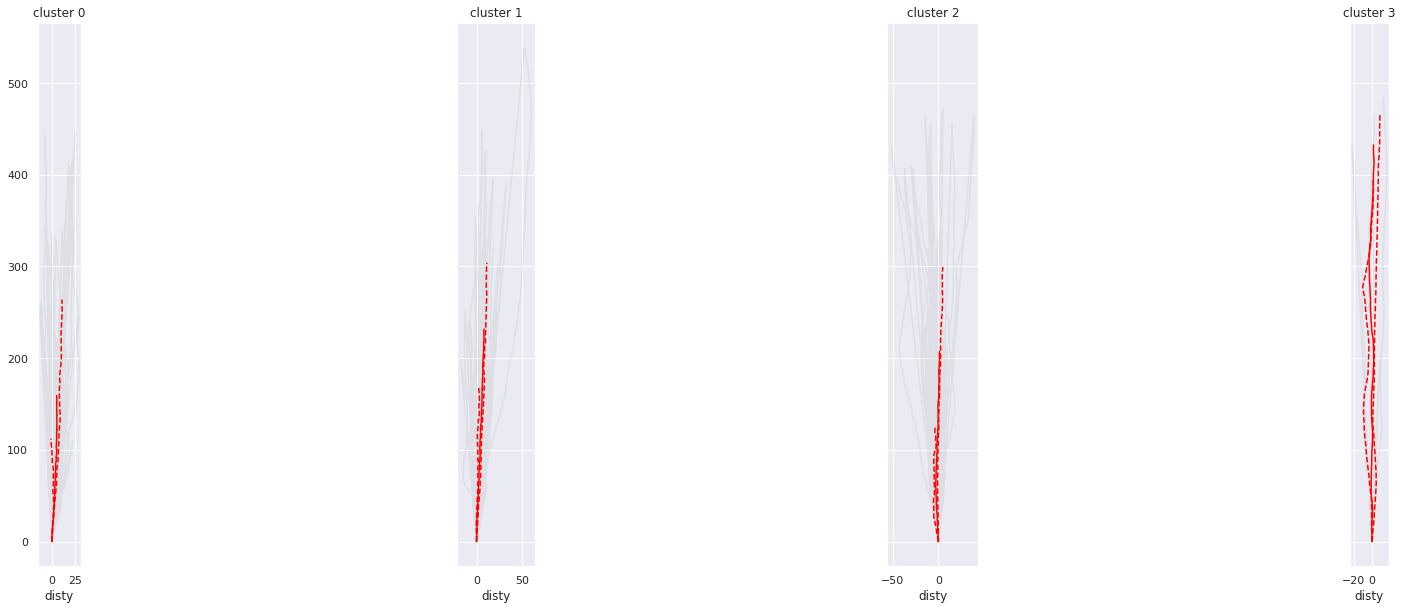

In [39]:
fig, axes = plt.subplots(ncols=max(labels)+1, figsize=(30, 10), sharey='row')

for cluster in sorted(labels):

    df_cluster = df_norm.query(f'cluster=={cluster}')\
                        [['distx', 'disty']]
    gb = df_cluster.groupby(level=0)
    df_median = gb.median()
    df_down = gb.quantile(0.25)
    df_up = gb.quantile(0.75)

    df_cluster.plot(ax=axes[cluster], alpha=0.05, style='k', x='disty', y='distx', title=f'cluster {cluster}')
    df_median.plot(ax=axes[cluster], style='r', x='disty', y='distx', title=f'cluster {cluster}')
    df_down.plot(ax=axes[cluster], style='r--', x='disty', y='distx', title=f'cluster {cluster}')
    df_up.plot(ax=axes[cluster], style='r--', x='disty', y='distx', title=f'cluster {cluster}')
    axes[cluster].set_aspect('equal')
    axes[cluster].get_legend().remove()

In the trajectory plot, the cluster are a bit more visible with **0** and **1** being mainly right corner and **2** being a left corner.

## Andrew plots of the encoder features

,encode_0,encode_1,encode_2,encode_3,encode_4,encode_5,encode_6,encode_7,cluster
corner_select,,,,,,,,,
12km-D5-AGGRESSIVE-SECONDARY28x41,0.044137,0.717148,-0.910041,0.136094,-0.142731,0.942378,0.169816,-1.096735,2
12km-D5-AGGRESSIVE-SECONDARY56x01,0.530999,0.383051,-0.529608,0.101580,0.286603,0.199557,0.831332,-0.090387,2
12km-D5-AGGRESSIVE-SECONDARY6x91,0.734869,-0.370584,-0.845876,-1.042340,-0.242826,-0.055261,1.520784,0.727375,1
13km-D1-DROWSY-SECONDARY2x14,-0.644983,0.491528,-0.238239,-0.152461,-0.754647,-0.244120,-0.659645,-0.457272,0
13km-D1-DROWSY-SECONDARY61x24,0.232243,0.884134,-0.785839,0.323067,0.370795,0.924723,0.601011,-0.909765,2


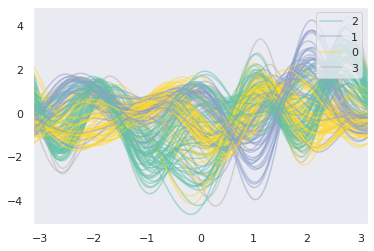

In [59]:
df_andrew = dfout[ dfout.columns[dfout.columns.str.contains('encode')].tolist() + ['cluster'] ]
display(df_andrew.head())
pd.plotting.andrews_curves(df_andrew, 'cluster', alpha=0.5, colormap='Set2');